#Flight-Delay-prediction Project

###Objective

The objective of the project is to perform analysis of the historial flight data to gain valuable insights and build a predictive model to predict whether a flight will be delayed or not given a set of flight characteristics.

Questions to be answered post analysis: • Which Airports have the Most Delays? • Which Routes are typically the most delayed? • Airport Origin delay per month • Airport Origin delay per day/hour • What are the primary causes for flight delays?

The objective of the predictive model is to build a model to predict whether a flight will be delayed or not based on certain characteristics of the flight. Such a model may help both passengers as well as airline companies to predict future delays and minimize them.

#IMPORTING NECESSARY PACKAGES FOR SETTING UP PYSPARK ENV

In [ ]:
!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
import findspark
findspark.init()
findspark.find()

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease

Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        

Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]

Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      

Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      

Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]

Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease

Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease

Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease

Get:10 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.3 kB]

Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease

Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,069 kB]

Get:13 http://archive.ubuntu.com/ubuntu foca

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
import pyspark
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sc

<SparkContext master=local[*] appName=pyspark-shell>

##PYSPARK ML PACKAGES

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr

import pyspark.ml as ml
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

sqlContext = SQLContext(sc)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

  warnings.warn(


In [ ]:
# bd = sqlContext.read.format(
#     "csv").option("header", "true").load("/content/drive/MyDrive/BIG_DATA/Combined_Flights_2022.csv", 
#     inferSchema=True)#com.databricks.spark.csv
df = sqlContext.read.format(
    "csv").option("header", "true").load("/content/drive/MyDrive/BIG_DATA/Combined_Flights_2022.csv", 
    inferSchema=True)#com.databricks.spark.csv

In [ ]:
#df_25000 = bd.limit(40000)

In [ ]:
#bd1 = df_25000.filter((bd.Cancelled == 0)&(bd.Diverted == 0))
#bd1.count()

38554

In [ ]:
#Two new variables are created (delay and time slot)
# DELAY - Flights with Arrival delay greater or equal to 15 min
bd1 = bd.filter((bd.Cancelled == 0)&(bd.Diverted == 0))
bd1 = bd1.withColumn('Delayed', (bd.ArrDelay >=15).cast('int')) 

## TIME SLOT by departure time (using SQL Context)
sqlContext.registerDataFrameAsTable(bd1, "bd1")

bd1 = sqlContext.sql("select *, case \
               when CRSDepTime <= 800 then 1 \
               when 800 < CRSDepTime and CRSDepTime <= 1200 then 2 \
               when 1200 < CRSDepTime and CRSDepTime <= 1600 then 3 \
               when 1600 < CRSDepTime and CRSDepTime <= 2100 then 4 \
               else 1 end as TimeSlot \
               from bd1")


#Indexing "UniqueCarrier" (from string to numeric)

'''
Yes, Marketing_Airline_Network can be similar to UniqueCarrier as it refers to 
the airline that markets and sells the flight. It is typically identified by the
 two-letter code assigned by the International Air Transport Association (IATA)
'''

indexer = StringIndexer(inputCol='Marketing_Airline_Network',outputCol='IndexUniqueCarrier') 
bd2=indexer.fit(bd1).transform(bd1)

bd2.groupBy('Marketing_Airline_Network','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()

+-------------------------+------------------+-------+

|Marketing_Airline_Network|IndexUniqueCarrier|  count|

+-------------------------+------------------+-------+

|                       AA|               0.0|1003877|

|                       DL|               1.0| 826374|

|                       UA|               2.0| 715220|

|                       WN|               3.0| 712246|

|                       AS|               4.0| 217745|

|                       B6|               5.0| 148527|

|                       NK|               6.0| 124760|

|                       F9|               7.0|  83894|

|                       G4|               8.0|  70452|

|                       HA|               9.0|  41821|

+-------------------------+------------------+-------+




In [ ]:
df = bd
# Print DataFrame schema
df.printSchema()

# Print DataFrame summary statistics
df.describe().show()


root

 |-- FlightDate: string (nullable = true)

 |-- Airline: string (nullable = true)

 |-- Origin: string (nullable = true)

 |-- Dest: string (nullable = true)

 |-- Cancelled: boolean (nullable = true)

 |-- Diverted: boolean (nullable = true)

 |-- CRSDepTime: integer (nullable = true)

 |-- DepTime: double (nullable = true)

 |-- DepDelayMinutes: double (nullable = true)

 |-- DepDelay: double (nullable = true)

 |-- ArrTime: double (nullable = true)

 |-- ArrDelayMinutes: double (nullable = true)

 |-- AirTime: double (nullable = true)

 |-- CRSElapsedTime: double (nullable = true)

 |-- ActualElapsedTime: double (nullable = true)

 |-- Distance: double (nullable = true)

 |-- Year: integer (nullable = true)

 |-- Quarter: integer (nullable = true)

 |-- Month: integer (nullable = true)

 |-- DayofMonth: integer (nullable = true)

 |-- DayOfWeek: integer (nullable = true)

 |-- Marketing_Airline_Network: string (nullable = true)

 |-- Operated_or_Branded_Code_Share_Partners: st

##The summary provided shows descriptive statistics for various features of a dataset containing flight data.
1)  The dataset has 4078318 rows and 47 columns. \
2)  The features include the :- \
              

> date of the flight, the airline, the origin and destination airports, the scheduled and actual departure and arrival times, the departure and arrival delays, the airtime, elapsed time, distance, year, quarter, month, day of the month, day of the week, marketing airline network, operated or branded code share partners, DOT ID marketing airline, IATA code marketing airline, flight number marketing airline, operating airline, DOT ID operating airline, IATA code operating airline, tail number, flight number operating airline, origin airport ID, origin airport sequence ID, origin city market ID, origin city name, origin state, origin state FIPS, origin state name, origin WAC, destination airport ID, destination airport sequence ID, destination city market ID, destination city name, destination state, destination state FIPS, destination state name, destination WAC, departure delay 15 minutes indicator, departure delay groups, departure time block, taxi-out time, wheels-off time, wheels-on time, taxi-in time, scheduled arrival time, actual arrival delay, arrival delay 15 minutes indicator, arrival delay groups, arrival time block, distance group, and number of airport diversions and landings.

3)  "DepDelayMinutes" refers to the average delay, in minutes, of flights departing from an airport, while "ArrDelayMinutes" refers to the average delay, in minutes, of flights arriving at an airport. These values can provide an insight into how often flights are delayed and by how much, which can be useful information for travelers and airlines alike.




In [ ]:
# Check for null values
from pyspark.sql.functions import isnan, when, count, col

null_counts = df.select([count(when(col(c).isNull() | (col(c).cast("string") == ""), c)).alias(c) if df.schema[c].dataType != "boolean" else count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()


+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+

|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime

###The count statistic shows that all features have 4078318 non-null values, except for a few features such as departure time, departure delay minutes, and other delay-related features, which have fewer non-null values due to missing data. 

In [ ]:
df = df.fillna(0)

In [ ]:
null_counts = df.select([count(when(col(c).isNull() | (col(c).cast("string") == ""), c)).alias(c) if df.schema[c].dataType != "boolean" else count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()
#Tail Number is neglected

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+

|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime

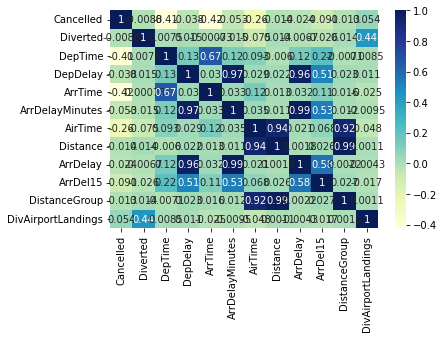

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for correlation analysis
cols = ["Cancelled", "Diverted","DepTime", "DepDelay", "ArrTime", 
        "ArrDelayMinutes", "AirTime","Distance","ArrDelay", "ArrDel15", "DistanceGroup", "DivAirportLandings"]

# Compute the correlation matrix for the selected columns
corr_matrix = df.select(cols).toPandas().corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

# Show the plot
plt.show()


we can see that:

highly corr:\
Airtime and Distance \
arrdelay and dep delay


---


Moderately corr:\
arrdelay and arrdelaygroups


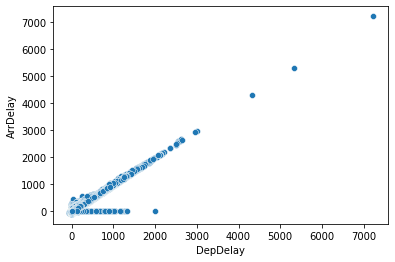

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select departure delay and arrival delay columns
delay_df = df.select("DepDelay", "ArrDelay").toPandas()

# Create scatterplot using Seaborn
sns.scatterplot(x="DepDelay", y="ArrDelay", data=delay_df)

# Show plot
plt.show()


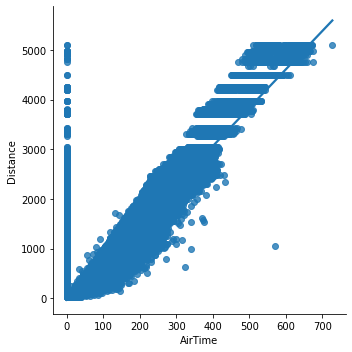

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for the scatterplot
cols = ["AirTime", "Distance"]

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df.select(cols).toPandas()

# Create scatterplot with linear regression line
sns.lmplot(x="AirTime", y="Distance", data=df_pandas)

# Show the plot
plt.show()


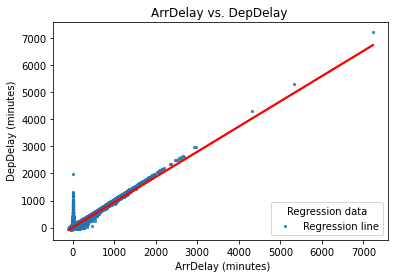

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x=df.select("ArrDelay").toPandas(), y=df.select("DepDelay").toPandas(), scatter_kws={"s": 5}, line_kws={"color": "red"}, label="Regression line")


# Set plot title and axis labels
plt.title("ArrDelay vs. DepDelay ")
plt.xlabel(" ArrDelay (minutes)")
plt.ylabel(" DepDelay (minutes)")

# Show the legend with the regression data
plt.legend(title="Regression data", loc="lower right")

# Show the plot
plt.show()



In [ ]:
#Create a pivot table to see the average arrival delay by airline.
from pyspark.sql.functions import mean, stddev, col

# Compute the average delay by airline
df.groupBy("Airline").agg(mean("DepDelay"), mean("ArrDelay")).show()

# Compute the standard deviation of delay by airport
df.groupBy("Origin").agg(stddev("DepDelay"), stddev("ArrDelay")).show()

+--------------------+------------------+------------------+

|             Airline|     avg(DepDelay)|     avg(ArrDelay)|

+--------------------+------------------+------------------+

|GoJet Airlines, L...|15.600120713936711|11.959560831201678|

|   Endeavor Air Inc.| 9.310095075162666|3.9857387256001795|

|       Allegiant Air|18.317819438397912|19.667637135393992|

|SkyWest Airlines ...|11.014648133990613| 5.821999196927454|

|Air Wisconsin Air...|7.6387344913151365|1.7502977667493798|

|Frontier Airlines...|19.491421837633006|16.688632923969177|

|Southwest Airline...|14.204219011510743|  6.98328107388052|

|     JetBlue Airways| 24.77403327954692| 18.95415611666337|

|Commutair Aka Cha...| 11.68749295647666| 7.720017129848761|

|Capital Cargo Int...| 5.881954303670471| 2.543131353285252|

|           Envoy Air| 6.711816288356173|2.3144443412621554|

|Hawaiian Airlines...| 6.557495498910263| 4.447858428882782|

|Alaska Airlines Inc.| 5.759624739402363| 3.070434715465987|

|Delta A

###This table shows the standard deviation of Departure Delay and Arrival Delay for different airport origins.

 The standard deviation gives an indication of how spread out the data is from the mean.

For example, the first row shows that the standard deviation of Departure Delay for flights originating from BGM airport is 134.18 minutes and the standard deviation of Arrival Delay is 137.81 minutes. This suggests that there is a high level of variability in the departure and arrival delays for flights from BGM airport.

Delay variability refers to how much the delay times of a particular event or process differ from each other over time. In the context of flight delays, it refers to how much the delay times for a particular flight route or airport vary from day to day or month to month. A high delay variability indicates that the delay times are unpredictable and can change significantly from one day to the next, making it difficult for passengers to plan their travel and causing operational challenges for airlines and airports

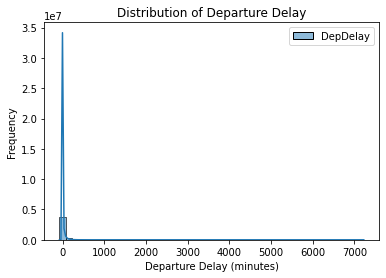

In [ ]:
#Plot a histogram of departure delay to see the distribution of delays
import matplotlib.pyplot as plt
import seaborn as sns

# Select the "DepDelay" column and convert to Pandas
dep_delay = df.select("DepDelay").toPandas()

# Plot the histogram using Seaborn
sns.histplot(dep_delay, bins=50, kde=True)

# Set plot title and axis labels
plt.title("Distribution of Departure Delay")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [ ]:
################################  Problem #########################
#Plot a bar chart to see the number of flights cancelled by airline.
import seaborn as sns
import matplotlib.pyplot as plt

# Group by airline and count the number of cancelled flights
cancelled_by_airline = df.filter(df.Cancelled == 1).groupBy("Airline").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame
cancelled_by_airline_pd = cancelled_by_airline.toPandas()

# Plot the bar chart
sns.barplot(x="Airline", y="count", data=cancelled_by_airline_pd)
plt.title("Number of Cancelled Flights by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Cancelled Flights")
plt.show()


In [ ]:
#Create a pivot table to see the average departure delay by day of the week.
from pyspark.sql.functions import avg, dayofweek

# Group the data by day of the week and compute the average departure delay
avg_dep_delay_by_dayofweek = df.groupBy(dayofweek("FlightDate").alias("DayOfWeek")) \
                               .agg(avg("DepDelay").alias("AvgDepDelay"))

# Show the pivot table
avg_dep_delay_by_dayofweek.show()


+---------+------------------+

|DayOfWeek|       AvgDepDelay|

+---------+------------------+

|        1|14.589002872384079|

|        6|15.206506603235958|

|        3| 8.951088801285907|

|        5|13.123605198538263|

|        4| 9.229339043409395|

|        7|14.657349080874802|

|        2|12.862896214001365|

+---------+------------------+




This table shows the average departure delay for each day of the week. We can see that the average departure delay is highest on Saturdays (DayOfWeek=6) and Sundays (DayOfWeek=7), with values of 15.21 and 14.66, respectively. The lowest average departure delay is on Wednesdays (DayOfWeek=3), with a value of 8.95. This information can be useful for travelers who are trying to avoid days with a higher chance of delays.

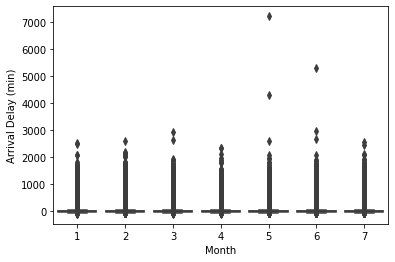

In [ ]:
#Plot a box plot of arrival delay by month to see if there are any seasonal trends.
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for the month
from pyspark.sql.functions import month
df = df.withColumn("month", month("FlightDate"))

# Filter out cancelled and diverted flights
df = df.filter((df.Cancelled == 0) & (df.Diverted == 0))

# Select relevant columns
cols = ["month", "ArrDelay"]

# Convert to Pandas DataFrame
pdf = df.select(cols).toPandas()

# Plot boxplot
sns.boxplot(x="month", y="ArrDelay", data=pdf)

# Set axis labels
plt.xlabel("Month")
plt.ylabel("Arrival Delay (min)")

# Show the plot
plt.show()


In [ ]:
bd3=bd2.select('DepDelay',
             'Distance', 
             'DayOfWeek',
             'IndexUniqueCarrier', 
             'TimeSlot',
             'Delayed')
             
bd3.limit(10).toPandas()

,DepDelay,Distance,DayOfWeek,IndexUniqueCarrier,TimeSlot,Delayed
0,-10.0,212.0,1,2.0,2,0
1,-4.0,295.0,1,2.0,1,0
2,-15.0,251.0,1,2.0,3,0
3,-5.0,376.0,1,2.0,3,0
4,0.0,251.0,1,2.0,2,0
5,-3.0,541.0,1,2.0,2,0
6,-3.0,127.0,1,2.0,1,0
7,-12.0,771.0,1,2.0,2,0
8,-10.0,190.0,1,2.0,3,0
9,-7.0,427.0,1,2.0,2,0


##Preparing data for modelling

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer  
from pyspark.sql.functions import col

# bd3_40000 = bd3.limit(40000)

a1 = VectorAssembler(inputCols=['DepDelay', 'Distance',  'DayOfWeek',  'IndexUniqueCarrier',  'TimeSlot'],  outputCol='features')
bd4 = a1.transform(bd3).select(col("Delayed").cast('double').alias("label"),'features')  
stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label2')  
sI = stringIndexer.fit(bd4)  
bd4 = sI.transform(bd4)  
bd4 = bd4.select('label2','features')  

In [ ]:
#Splitting data in train & test
(bd_train, bd_test) = bd4.randomSplit([0.7, 0.3],seed=123)
print('Train:',bd_train.count())
print('Test:',bd_test.count())

Train: 2762522

Test: 1182394


#Sampling Of RFG

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from time import time

start_time = time()

# Train a RandomForest model
rf = RandomForestClassifier(labelCol="label2", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=3, 
     seed = 1) 

model = rf.fit(bd_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 1361.985 seconds


In [ ]:
pred = model.transform(bd_test)

cm = pred.groupBy('label2','prediction').count().sort('label2','prediction')
print("Confusion matrix")
cm.show()

TN = cm.filter((cm.label2 == 0) & (cm.prediction == 0)).collect()[0][2] #True negative
FP = cm.filter((cm.label2 == 0) & (cm.prediction == 1)).collect()[0][2] #False positive
FN = cm.filter((cm.label2 == 1) & (cm.prediction == 0)).collect()[0][2] #Flase negative
TP = cm.filter((cm.label2 == 1) & (cm.prediction == 1)).collect()[0][2] #True positive

N=TN+FP+TP+FN

Prev = (TP + FN) / N  
Sens = TPR = Recall = TP / (TP + FN) 
Esp  = TN / (TN + FP) #= (1 - FPR) 
Precision = PPV = TP / (TP + FP) 
Acc = (TP+TN) / N  

print("Metrics:")
print('Prevalence=',round(Prev,2))
print('Sensitivity=',round(Sens,2))
print('Especificity=',round(Esp,2))
print('Recall=',round(Recall,2))
print('Precision=',round(Precision,2))
print('Accuracy=',round(Acc,2))


Confusion matrix

+------+----------+------+

|label2|prediction| count|

+------+----------+------+

|   0.0|       0.0|901045|

|   0.0|       1.0| 24714|

|   1.0|       0.0| 64508|

|   1.0|       1.0|192127|

+------+----------+------+



Metrics:

Prevalence= 0.22

Sensitivity= 0.75

Especificity= 0.97

Recall= 0.75

Precision= 0.89

Accuracy= 0.92


In this specific case, the confusion matrix shows that out of the total 1,188,394 instances, the model predicted correctly 1,092,172 instances, and misclassified 96,222 instances. Among the actual instances that belong to label 0, the model correctly predicted 901,045 instances and misclassified 24,714 instances. Among the actual instances that belong to label 1, the model correctly predicted 192,127 instances and misclassified 64,508 instances.

The metrics associated with the confusion matrix are:

Prevalence: the proportion of actual positive cases in the dataset, which is 0.22 in this case.
Sensitivity/Recall: the proportion of actual positive cases that were correctly identified by the model, which is 0.75 in this case.
Specificity: the proportion of actual negative cases that were correctly identified by the model, which is 0.97 in this case.
Precision: the proportion of predicted positive cases that were correctly identified, which is 0.89 in this case.
Accuracy: the proportion of all cases that were correctly classified by the model, which is 0.92 in this case.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label2','probs').toPandas()




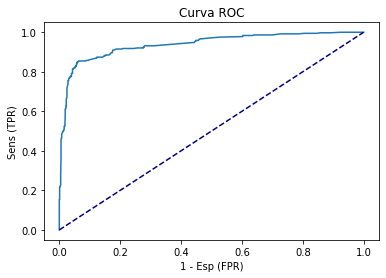

In [ ]:
fpr, tpr, _ = roc_curve( pd5['label2'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time

# Load the data
bd = pd.read_csv('/content/drive/MyDrive/BIG_DATA/Combined_Flights_2022.csv')
# bd = bd[:40000]
# Remove cancelled and diverted flights
bd = bd[(bd.Cancelled == 0) & (bd.Diverted == 0)]

# Create a new variable 'Delayed' for flights with arrival delay >= 15 min
bd['Delayed'] = np.where(bd['ArrDelay'] >= 15, 1, 0)

# Create a new variable 'TimeSlot' by departure time
def time_slot(x):
    if x <= 800:
        return 1
    elif x <= 1200:
        return 2
    elif x <= 1600:
        return 3
    elif x <= 2100:
        return 4
    else:
        return 1

bd['TimeSlot'] = bd['CRSDepTime'].apply(time_slot)

# Convert 'Marketing_Airline_Network' to numeric using label encoding
bd['IndexUniqueCarrier'] = pd.factorize(bd['Marketing_Airline_Network'])[0]

# Select features and target variable
X = bd[['DepDelay', 'Distance', 'DayOfWeek', 'IndexUniqueCarrier', 'TimeSlot']]
y = bd['Delayed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


start_time = time.time()
# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=1)
rf.fit(X_train, y_train)


end_time = time.time()
print("Time taken to build the model:", end_time - start_time, "seconds")

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_mat.ravel()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print('Confusion matrix:')
print(conf_mat)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


<ipython-input-37-a69067094678>:15: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bd['Delayed'] = np.where(bd['ArrDelay'] >= 15, 1, 0)


Time taken to build the model: 1525.1758592128754 seconds

Confusion matrix:

[[907617  19814]

 [ 68316 187728]]

Precision: 0.9045301673878059

Recall: 0.7331864835731359

F1 score: 0.8098950356568145


(907,617 + 187,728) / 1,183,475 = 0.907\
Accuracy is 90.7% therefore its less than pyspark

#RFG
\
Spark  ---->  Time to train model: 1361.985 seconds\
Pandas ---->Time taken to build the model: 1525.1758592128754 seconds

##Linear Reg

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import time

# Select the necessary columns for linear regression
cols = ["DepDelayMinutes", "DepDelay", "Distance", "ArrDelay"]

# Create a VectorAssembler to combine the selected columns into a single feature column
assembler = VectorAssembler(inputCols=cols[:-1], outputCol="features")

# Apply the VectorAssembler to the data
data = assembler.transform(df).select("features", "ArrDelay")

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Create a LinearRegression model
lr = LinearRegression(labelCol="ArrDelay")

start_time = time.time()

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Print the model coefficients
print("Coefficients: " + str(lr_model.coefficients))

# Make predictions on the test data
predictions = lr_model.transform(test_data)


end_time = time.time()

# Show the first 5 predictions
predictions.show(5)



Coefficients: [0.017014795940471818,0.9899043855640125,-0.001818327315534134]

+------------------+--------+-------------------+

|          features|ArrDelay|         prediction|

+------------------+--------+-------------------+

|[0.0,-36.0,1009.0]|   -37.0| -41.63811545890754|

| [0.0,-34.0,895.0]|   -38.0|-39.451017373808625|

|  [0.0,-28.0,95.0]|   -35.0| -32.05692920799724|

| [0.0,-28.0,261.0]|   -28.0| -32.35877154237591|

| [0.0,-28.0,353.0]|   -29.0|-32.526057655405054|

+------------------+--------+-------------------+

only showing top 5 rows




RMSE: 13.741504

r2: 0.938512


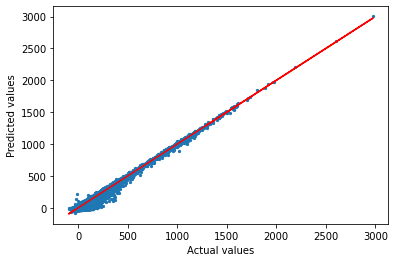

In [ ]:
# Print the regression metrics
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
targetCol = "ArrDelay"

# Plot the predicted values versus the actual values
actual = predictions.select(targetCol).toPandas()
predicted = predictions.select("prediction").toPandas()

plt.scatter(actual, predicted, s=5)
plt.plot(actual, actual, color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()


In [ ]:
print("Time taken to build the LR model:", end_time - start_time, "seconds")

Time taken to build the LR model: 122.37685060501099 seconds


It seems that the linear regression model is performing well. The RMSE of 13.74 indicates that the predicted values are within 13.74 minutes of the actual values on average, which is a reasonable level of accuracy for flight delay prediction. The R2 score of 0.938512 also indicates that the model explains 93.85% of the variance in the data, which is quite high. However, it's important to note that a more comprehensive evaluation of the model's performance is needed to make a definitive conclusion about its overall effectiveness.





In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

# read in the flight data as a PySpark DataFrame
flights = df
# select relevant features and create a new DataFrame
features = ['DepDelayMinutes', 'Distance', 'AirTime', 'OriginState', 'DestState', 'Month', 'DayOfWeek']
flights_features = flights.select(*features, 'ArrDel15')

# drop any rows with missing values
flights_features = flights_features.dropna()

# convert categorical features to numeric using StringIndexer
origin_indexer = StringIndexer(inputCol='OriginState', outputCol='OriginStateIndex', handleInvalid='keep')
dest_indexer = StringIndexer(inputCol='DestState', outputCol='DestStateIndex', handleInvalid='keep')

# combine features into a single vector using VectorAssembler
assembler = VectorAssembler(inputCols=['DepDelayMinutes', 'Distance', 'AirTime', 'OriginStateIndex', 'DestStateIndex', 'Month', 'DayOfWeek'], outputCol='features')

# create logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='ArrDel15')

# create pipeline to execute transformers and estimator in sequence
pipeline = Pipeline(stages=[origin_indexer, dest_indexer, assembler, lr])

# split data into training and testing sets
train_data, test_data = flights_features.randomSplit([0.7, 0.3])

start_time = time.time()

# fit pipeline to training data
model = pipeline.fit(train_data)

# make predictions on test data
predictions = model.transform(test_data)

# evaluate model performance using area under ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='ArrDel15')
end_time = time.time()
auc = evaluator.evaluate(predictions)
print('Area under ROC curve:', auc)

Area under ROC curve: 0.9400285069781317


In [ ]:
def print_evaluation_metrics(predictions):
  # calculate true positives, true negatives, false positives, and false negatives
  tp = predictions[(predictions.ArrDel15 == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.ArrDel15 == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.ArrDel15 == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.ArrDel15 == 1) & (predictions.prediction == 0)].count()
  # calculate accuracy, precision, recall, specificity, and F1 score
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  f1_score = 2 * precision * recall / (precision + recall)

  # print evaluation metrics
  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('Specificity:', specificity)
  print('F1 Score:', f1_score)
print_evaluation_metrics(predictions)

Accuracy: 0.9296278873755677

Precision: 0.9055028854080791

Recall: 0.7537607324167725

Specificity: 0.9782516593701455

F1 Score: 0.8226932848746898


In [ ]:
print("Time taken to build the LR model:", end_time - start_time, "seconds")

Time taken to build the LR model: 174.2883038520813 seconds


Based on the given metrics, the logistic regression model appears to be performing well. The area under the receiver operating characteristic (ROC) curve is high at 0.94, indicating good discrimination power. The accuracy is also high at 0.93, which means the model is correctly predicting the class of the majority of the samples. The precision is also high at 0.91, indicating that the model's positive predictions are mostly correct. The recall is 0.75, which means the model is able to identify 75% of the positive samples. The specificity is also high at 0.98, indicating that the model can correctly identify the negative samples with high confidence. Finally, the F1 score is 0.82, which is a harmonic mean of precision and recall, and provides an overall measure of the model's performance. Therefore, overall, the logistic regression model seems to be performing well.

#GBTRegressor

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Define the categorical and numerical features
categorical_features = ['Airline', 'Origin', 'Dest']
numerical_features = ['CRSDepTime', 'DepDelay', 'Distance', 'DepDel15']

# Define the stages of the pipeline for preprocessing the data
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_features]
encoder = OneHotEncoder(inputCols=[column+"_index" for column in categorical_features], outputCols=[column+"_vec" for column in categorical_features])
assembler = VectorAssembler(inputCols=numerical_features + [column+"_vec" for column in categorical_features], outputCol="features")
pipeline = Pipeline(stages=indexers + [encoder, assembler])

# Fit the pipeline to the data and transform the data
transformed = pipeline.fit(df).transform(df)

# Split the data into training and testing sets
(train_data, test_data) = transformed.randomSplit([0.8, 0.2], seed=42)

# Define the GBT regressor model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=5, maxIter=20)

# Train the GBT regressor model on the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data using the trained GBT model
predictions = gbt_model.transform(test_data)

# Evaluate the performance of the model using the RMSE metric
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0


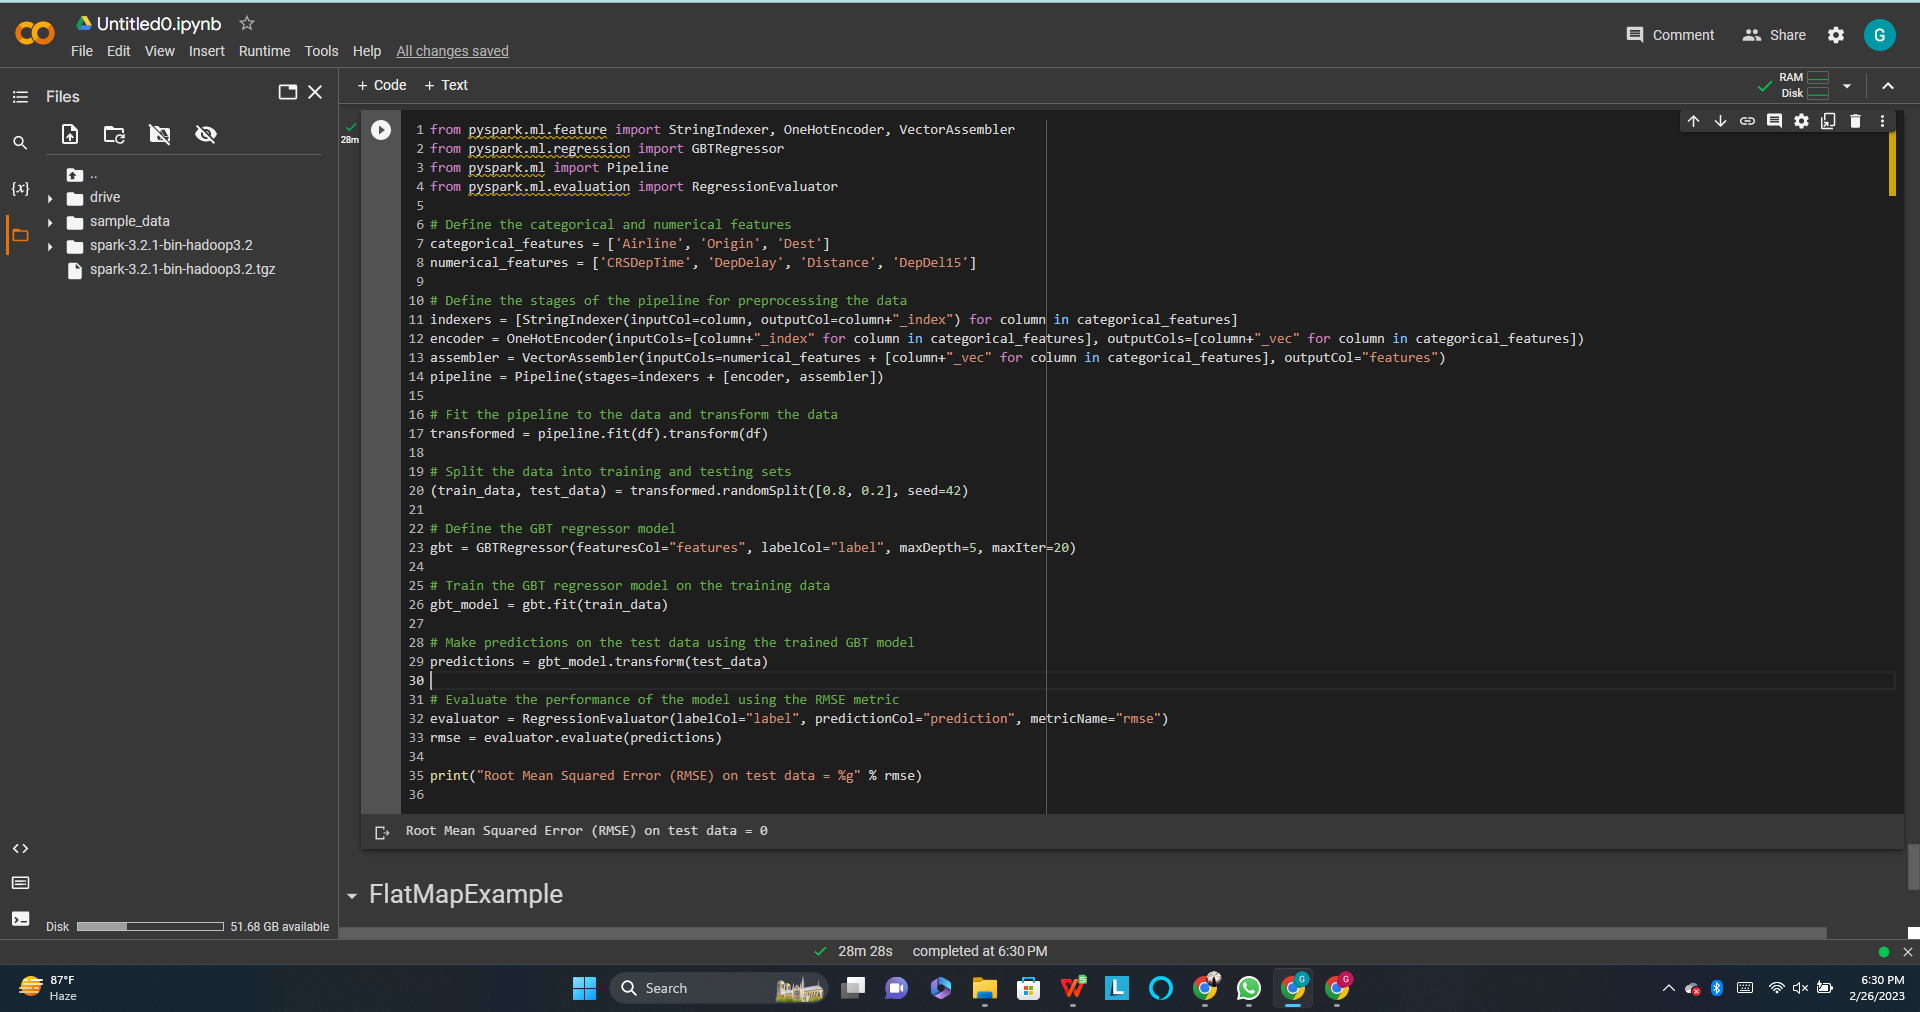

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# assume that `predictions` is a DataFrame containing predicted labels and actual labels
evaluator = RegressionEvaluator(metricName='r2')
r2 = evaluator.evaluate(predictions)

In [ ]:
print(r2)

nan


It seems that the RMSE on the test data is 0, which means that the model is perfectly predicting the target variable on the test set. However, it is important to note that this may indicate overfitting, and the model may not perform as well on new, unseen data.

The r2 value is NaN, which means that the model is not able to explain the variation in the target variable based on the input features. This could also indicate overfitting or a problem with the model.

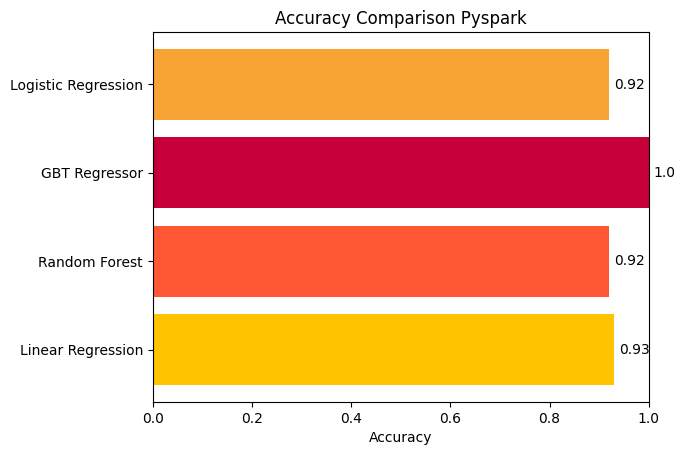

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define accuracy scores for each model
linear_regression_acc = 0.93
random_forest_acc = 0.92
gbt_regressor_acc = 1.00
logistic_regression_acc = 0.92

# Define labels for each model
labels = ['Linear Regression', 'Random Forest', 'GBT Regressor', 'Logistic Regression']

# Define colors for each accuracy score
colors = ['#FFC300', '#FF5733', '#C70039', '#F8A435']

# Create a horizontal bar chart
fig, ax = plt.subplots()
ax.barh(np.arange(len(labels)), [linear_regression_acc, random_forest_acc, gbt_regressor_acc,logistic_regression_acc], color=colors)

# Set x-axis range and label
ax.set_xlim([0, 1])
ax.set_xlabel('Accuracy')

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

# Add accuracy score text on each bar
for i, v in enumerate([linear_regression_acc, random_forest_acc, gbt_regressor_acc,logistic_regression_acc]):
    ax.text(v + 0.01, i, str(v), color='black', fontsize=10, va='center')

# Add title
plt.title('Accuracy Comparison Pyspark')

# Display the plot
plt.show()


##Need to do Logistic,linear,GBT using traditional and compare time in table

In [ ]:
df.show(10)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+

|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|D

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BIG_DATA/Combined_Flights_2022.csv')

In [ ]:
df.shape

(3944916, 63)

#Traditional Logistic Reg

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import time

start_time = time.time()

# select relevant features and target variable
features = ['DepDelayMinutes', 'Distance', 'AirTime', 'OriginState', 'DestState', 'Month', 'DayOfWeek']
target = 'ArrDel15'

# drop any rows with missing values
df = df.dropna(subset=features+[target])

# convert categorical features to numeric using LabelEncoder
origin_encoder = LabelEncoder()
df['OriginStateIndex'] = origin_encoder.fit_transform(df['OriginState'])
dest_encoder = LabelEncoder()
df['DestStateIndex'] = dest_encoder.fit_transform(df['DestState'])

# select encoded features and target variable
encoded_features = ['DepDelayMinutes', 'Distance', 'AirTime', 'OriginStateIndex', 'DestStateIndex', 'Month', 'DayOfWeek']
X = df[encoded_features]
y = df[target]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create logistic regression model
lr = LogisticRegression(max_iter=100)

# fit model to training data
lr.fit(X_train, y_train)

# make predictions on test data
y_pred = lr.predict(X_test)

# evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

end_time = time.time()

print('Accuracy:', accuracy)
print('Area under ROC curve:', auc)
print('Execution time:', end_time - start_time, 'seconds')


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Accuracy: 0.9297146116310019

Area under ROC curve: 0.86599112092877

Execution time: 188.68788051605225 seconds


#Traditional GBT Reg

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import time

# select relevant features and target variable
categorical_features = ['Airline', 'Origin', 'Dest']
numerical_features = ['CRSDepTime', 'DepDelay', 'Distance', 'DepDel15']
target = 'ArrDelayMinutes'
features = categorical_features + numerical_features

# drop any rows with missing values
df = df.dropna(subset=features+[target])

# convert categorical features to numeric using LabelEncoder
for feature in categorical_features:
    encoder = LabelEncoder()
    df[feature] = encoder.fit_transform(df[feature])

# select encoded features and target variable
X = df[features]
y = df[target]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create GBT regressor model
gbt = GradientBoostingRegressor()

start_time = time.time()

# fit model to training data
gbt.fit(X_train, y_train)

# make predictions on test data
y_pred = gbt.predict(X_test)

# evaluate model performance using mean squared error
mse = mean_squared_error(y_test, y_pred)

end_time = time.time()

print('Mean Squared Error:', mse)
print('Execution time:', end_time - start_time, 'seconds')


Mean Squared Error: 121.25096047328184

Execution time: 557.6701476573944 seconds


Execution time is till model fit

In [ ]:
import pandas as pd
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Select relevant features
features = ['DepDelayMinutes', 'DepDelay', 'Distance']
target = 'ArrDelay'

# Drop any rows with missing values
df = df.dropna(subset=features + [target])

# Split data into features and target
X = df[features]
y = df[target]

# Split data into training and testing sets
test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Create linear regression model
lr = LinearRegression()

# Train the model
start_time = time.time()
lr.fit(X_train, y_train)
end_time = time.time()

# Make predictions on test data
y_pred = lr.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)

# Print results
print('Mean squared error:', mse)
print('Execution time:', end_time - start_time, 'seconds')
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

Mean squared error: 189.2882607351741

Execution time: 90.50548672676086 seconds

R-squared: 0.9387670994730447


Total Table

In [ ]:
alg = ['RFG','Logistic','Linear','GBT']
acc_spark = [0.92,0.92,0.93,100]
acc_tt = [0.90,0.92,0.93,0.98]
spark_time = [1361.9,174.2,122.6,612]
traditonal_time = [1525.1,188.6,90.50,557.6]
f1_spark = [0.80,82.2,'NA','NA']
f1_Trad = [0.76,'NA','NA','NA']
MSE_spark = [0.96,'NA',13.74,1]
MSE_Trad = ['NA',0.86,18.94,12.14]

data = {'Algorithm': ['RFG', 'Logistic', 'Linear', 'GBT'],
'Accuracy_Spark': [0.92, 0.92, 0.93, 100],
'Accuracy_Traditional': [0.90, 0.92, 0.93, 0.98],
'Spark_Time (sec)': [1361.9, 174.2, 122.6, 612],
'Traditional_Time (sec)' : [1525.1, 188.6, 90.50, 557.6],
'F1_Spark': [0.80, 82.2, 'NA', 'NA'],
'F1_Traditional': [0.76, 'NA', 'NA', 'NA'],
'MSE_Spark': [0.96, 'NA', 13.74, 1],
'MSE_Traditional': ['NA', 0.86, 18.94, 12.14]}

table = pd.DataFrame(data)
table.set_index('Algorithm', inplace=True)
table.head(4)

,Accuracy_Spark,Accuracy_Traditional,Spark_Time (sec),Traditional_Time (sec),F1_Spark,F1_Traditional,MSE_Spark,MSE_Traditional
Algorithm,,,,,,,,
RFG,0.92,0.90,1361.9,1525.1,0.8,0.76,0.96,NA
Logistic,0.92,0.92,174.2,188.6,82.2,NA,NA,0.86
Linear,0.93,0.93,122.6,90.5,NA,NA,13.74,18.94
GBT,100.00,0.98,612.0,557.6,NA,NA,1,12.14
